In [51]:
import random
import time
import enum
import math
from collections import namedtuple
from multiprocessing.pool import Pool
from typing import Tuple, NamedTuple, List
from tqdm import tqdm

import numpy as np
import pandas as pd
import pylab as plt
import networkx as nx
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl

from functions_networks import network_stats, find_parameters_density

from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector

In [52]:
number_nodes=240 #5imp, 20, 10 range. n=120, t=30s, density range=1-0.027, n=240, t=140s, density range=+-0.02, n=720, t=1700s, density range=+-0.016
objective_density_u=0.15 #based on dumbells number
implementations_u=10 #how many graphs we analyze per "ephoch"
p_stochaisc_smallworld=0.05 #extra parameter small world, changes clustering coeff but not density. higher=less clustering.
edges_barabassi=0.5 #percentage of connections that the elite have. higher=more clustering (from 0.5 on, before it seems to be flat)
range_barabassi_p_u=20 #parameter space for finding optimal in barabassi num1. higuer=closer to objective density
range_barabassi_anisotropy_u=10 #parameter space for finding optimal in barabassi num2. higuer=closer to objective density

parameters caveman 6 40 parameters windmill 6 41 parameters small world 240 40 0.05 parameters barabassi 240 30 120 0.9499999999999998


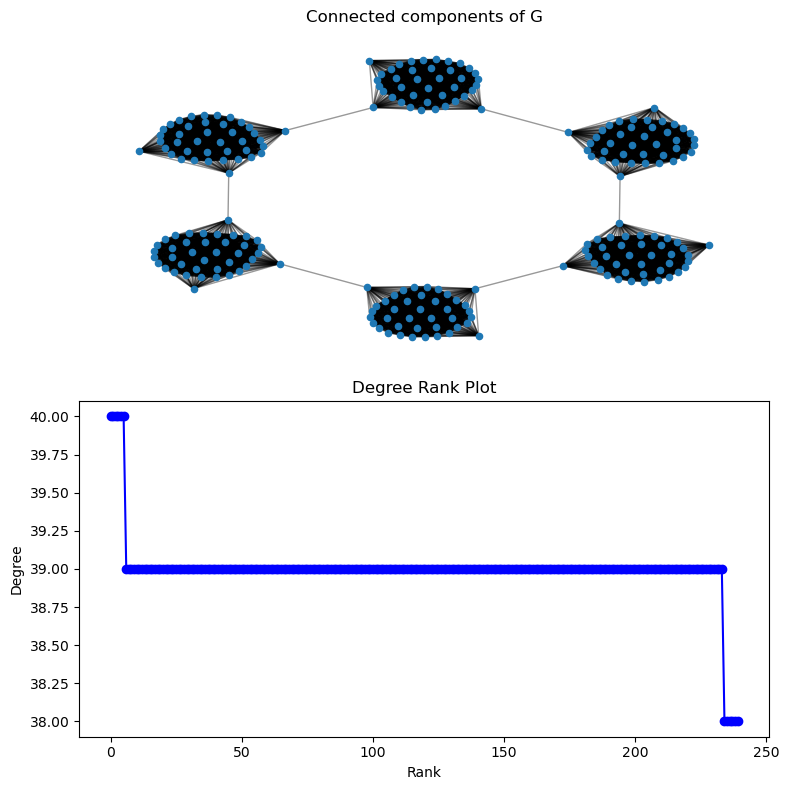

density 0.16317991631799164 clustering coeff 0.9961875843454763


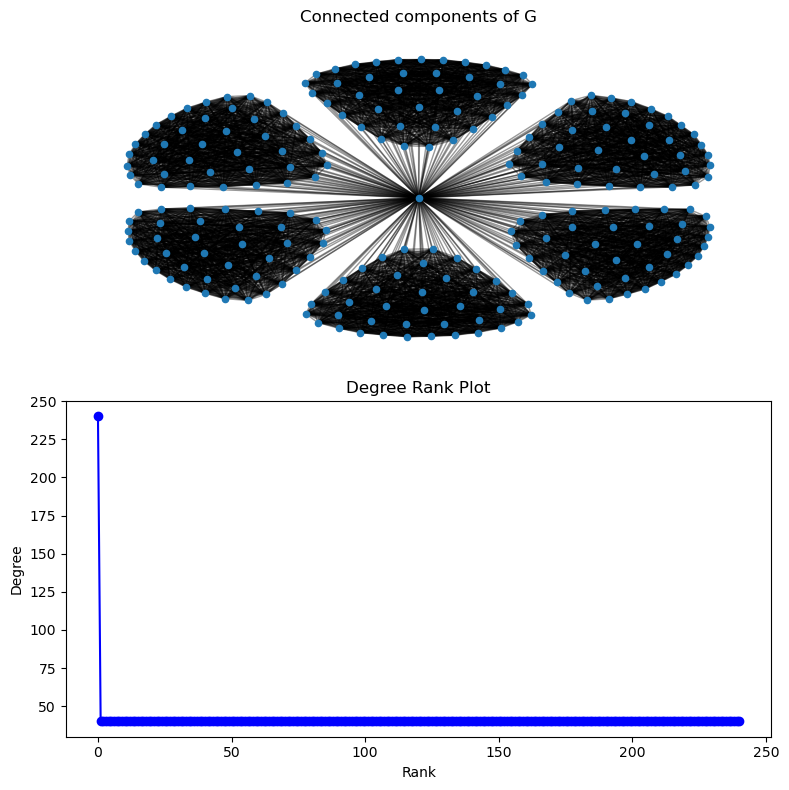

density 0.17012448132780084 clustering coeff 0.9965277174950954


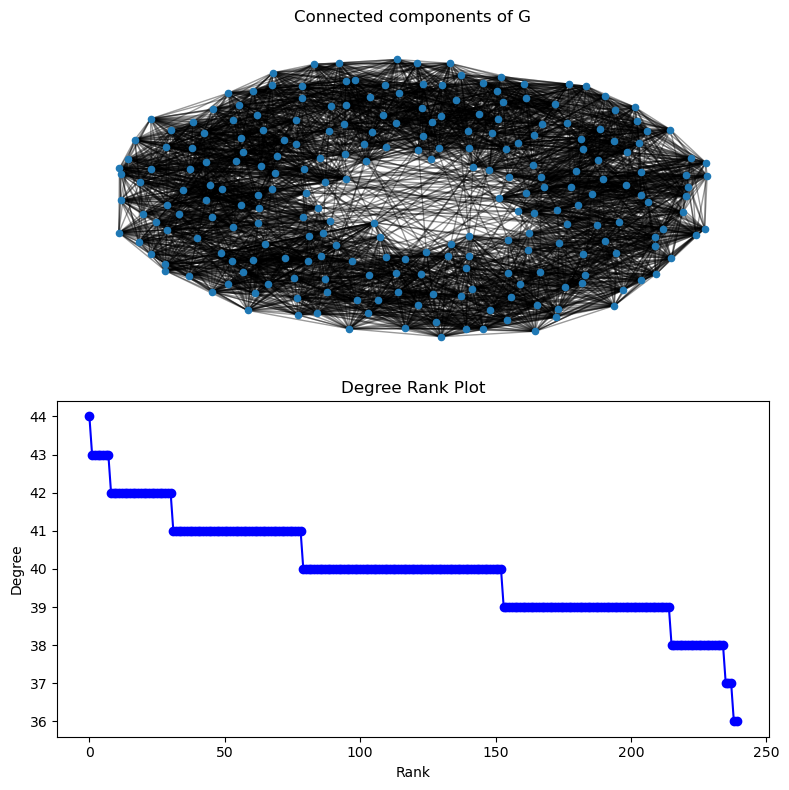

density 0.16736401673640167 clustering coeff 0.6300676753416367


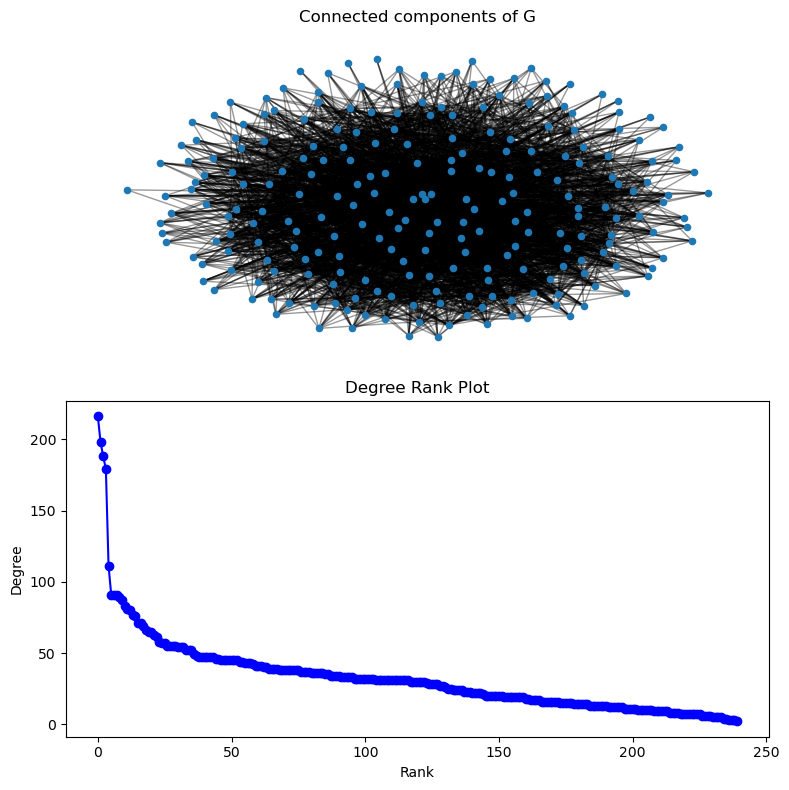

density 0.13807531380753138 clustering coeff 0.45265383974147866


(None, None)

In [53]:
n=number_nodes
objective_density=objective_density_u
implementations=implementations_u
range_barabassi_p=range_barabassi_p_u  
range_barabassi_anisotropy=range_barabassi_anisotropy_u
[l_caveman, k_caveman, l_windmill, k_windmill, k_smallworld, k_barabassi, l_barabassi, p_barabassi]=find_parameters_density(n,p_stochaisc_smallworld,edges_barabassi, range_barabassi_anisotropy, range_barabassi_p, implementations, objective_density)
print("parameters caveman", l_caveman, k_caveman, "parameters windmill", l_windmill, k_windmill,"parameters small world", n, k_smallworld, p_stochaisc_smallworld, "parameters barabassi", n, k_barabassi, l_barabassi, p_barabassi)
graph_caveman = nx.connected_caveman_graph(l_caveman,k_caveman)
network_stats(graph_caveman)
graph_windmill = nx.windmill_graph(l_windmill,k_windmill)
network_stats(graph_windmill)
graph_smallworld = nx.watts_strogatz_graph(n,k_smallworld, p_stochaisc_smallworld)
network_stats(graph_smallworld)
graph_barabassi = nx.dual_barabasi_albert_graph(n,k_barabassi, l_barabassi, p_barabassi)
network_stats(graph_barabassi)

In [54]:
# setup the opinion range of the agents
class opinion(enum.IntEnum):
    disagree = 0
    believe = 1
    unsure = 2

In [55]:
# stochasticity generator
def stochastic(probability):
    
    random_number = random.uniform(0, 1)
    
    if probability == 0:
        return False
    elif random_number < probability:
        return True
    else:
        return False

In [56]:
# setup agent properties
class my_agent(Agent):

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.state = opinion.disagree  # by default agents disagree -> the first one with believe is then given in the model -> need to think of how to handle unsure

    # listen to neighbors and stochastically change opinion accordingly
    def listen(self):

        # find neighbors
        neighbors = self.model.grid.get_neighbors(self.pos, include_center=False)

        if len(neighbors) > 0:
            
            for neighbor in neighbors:  #maybe we should shuffle the neighbors iterator here

                neighbor_obj = self.model.schedule.agents[neighbor]

                # if else for possible state transitions depending on the neighbor 
                # NOTE: this could probably be done better, but does the job for now
                # will expand this when we know exactly how opinion change is mediated, i.e. by what variables etc.
                # here "unsure" neighbors have no impact on the own opinion
                if self.state != neighbor_obj.state:
                                                        
                    #print("this is the agents own opinion " + str(self.state))
                    #print("this is the neighbors opinion " + str(neighbor_obj.state))
                    
                    if self.state == opinion.disagree and neighbor_obj.state == opinion.believe:
                            
                            # stochastically change state to "unsure"
                            if stochastic(model.p_opinion_change):
                                self.state = opinion.unsure            
                        
                    elif self.state == opinion.believe and neighbor_obj.state == opinion.disagree:
                            
                            # stochastically change state to "unsure"
                            if stochastic(model.p_opinion_change):
                                self.state = opinion.unsure 
                                            
                    elif self.state == opinion.unsure:
                        
                        if neighbor_obj.state == opinion.disagree:
                            
                            # stochastically change state to "disagree"
                            if stochastic(model.p_opinion_change):
                                self.state = opinion.disagree 
                        
                        elif neighbor_obj.state == opinion.believe:
                            
                            # stochastically change state to "believe"
                            if stochastic(model.p_opinion_change):
                                self.state = opinion.believe     
                        
                    #print("@ end of listen: this is the agents own opinion " + str(self.state))
                    #print("@ end of listen: this is the neighbors opinion " + str(neighbor_obj.state))               
                    
                
    # step funciton, i.e. the actions an agent can take when the model evolves for a time step
    def step(self):
        self.listen()
        

In this cell is where one needs to change the network type and other model parameters

We start with windmill, we will repeat this with the same parameters for all network types

In [83]:
graph_model=graph_smallworld
perc_initial_believers=0.1
p_opinion_change_u=0.05
steps_u=10 #for now, for simplicity, we run model as many times as we analyze graphs

In [84]:
class network_model(Model):
       
    def __init__(self, population_size = number_nodes, n_initial_believers = int(np.floor(perc_initial_believers*number_nodes)), p_opinion_change = p_opinion_change_u):
                
        # build the network:
        self.num_nodes = population_size  
        self.G = graph_model
        self.grid = NetworkGrid(self.G)
        
        
        # scheduling
        self.schedule = RandomActivation(self)
        self.running = True # I assume this is to make it run?
        
        self.initial_believers = 1 #this could be changed and doesnt need to be here
        
        self.p_opinion_change = p_opinion_change # chance that listening changes opinion

        # populate network with agents
        for i, node in enumerate(self.G.nodes(), start = 1):
            a = my_agent(i, self) 
            self.schedule.add(a)
            # add agent
            self.grid.place_agent(a, node) # hence agent id = agent pos
            
        # make some agents believers from the start
        initial_believers = random.sample(self.schedule.agents, n_initial_believers)
       
        for i in initial_believers:

            i.state = opinion.believe
           
        # something to collect data into    
        self.datacollector = DataCollector(
            agent_reporters={"State": "state"})

    # model step (same as agent step but for the model, i.e. the model collects data at every step, etc.)
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        


In [85]:
model = network_model(population_size = number_nodes, n_initial_believers = int(np.floor(perc_initial_believers*number_nodes)), p_opinion_change = p_opinion_change_u)

In [86]:
# convenience function to initiate and run model (parameter exploration in mind)
def initiate_and_run_model(steps):

    model = network_model(population_size = number_nodes, n_initial_believers = int(np.floor(perc_initial_believers*number_nodes)), p_opinion_change = p_opinion_change_u)
    
    for i in range(steps):
        model.step()
    
    return model
#convenience function to collect plotable data
def sum_agents(model):
    
    agent_data = model.datacollector.get_agent_vars_dataframe()
    # sum up different opinions each (time) step
    agents_summed = pd.pivot_table(agent_data.reset_index(), index = 'Step', columns = 'State', aggfunc = np.size, fill_value = 0)    
    # relabel
    labels = ['Disagree','Believer','Unsure']
    agents_summed.columns = labels[:len(agents_summed.columns)]
    return agents_summed
# quick visual sanity check on opinion evolution
def plot_agent_opinion(model):
    steps = model.schedule.steps
    X = sum_agents(model)
    X.plot(lw = 4, alpha = 0.8)

# nicer network figure where nodes are color coded  
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
def plot_graph_colours_opinion(model):
    color_code = ListedColormap(["lightblue", "orange", "green",])

    states = [int(i.state) for i in model.grid.get_all_cell_contents()]

    colors = [color_code(i) for i in states]
    return nx.draw(model.G, node_size = 10, edge_color = 'black', node_color = colors)

      Disagree  Believer  Unsure
Step                            
0          216        24       0
1          218         6      16
2          228         2      10
3          238         0       2
4          240         0       0
5          240         0       0
6          240         0       0
7          240         0       0
8          240         0       0
9          240         0       0
None


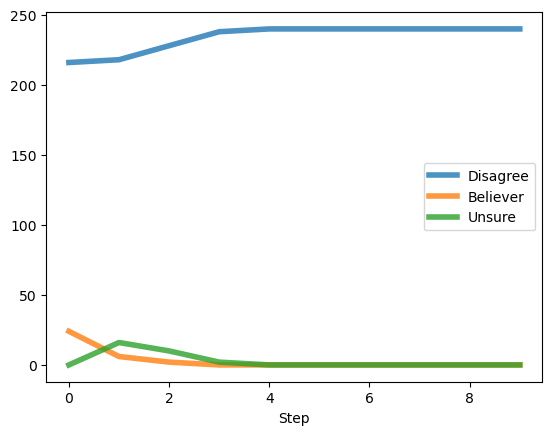

In [87]:
model_ran = initiate_and_run_model(steps_u)
print(sum_agents(model_ran))
print(plot_agent_opinion(model_ran))

print(plot_graph_colours_opinion(model_ran))

[[240. 240. 240. 240. 240. 240. 240. 240. 240. 240.]
 [240. 240. 240. 240. 240. 240. 240. 240. 240. 240.]
 [240. 240. 240. 240. 240. 240. 240. 240. 240. 240.]
 [240. 240. 240. 240. 240. 240. 240. 240. 240. 240.]
 [240. 240. 240. 240. 240. 240. 240. 240. 240. 240.]
 [240. 240. 240. 240. 240. 240. 240. 240. 240. 240.]
 [240. 240. 240. 240. 240. 240. 240. 240. 240. 240.]
 [240. 240. 240. 240. 240. 240. 240. 240. 240. 240.]
 [240. 240. 240. 240. 240. 240. 240. 240. 240. 240.]
 [240. 240. 240. 240. 240. 240. 240. 240. 240. 240.]
 [240. 240. 240. 240. 240. 240. 240. 240. 240. 240.]
 [240. 240. 240. 240. 240. 240. 240. 240. 240. 240.]
 [240. 240. 240. 240. 240. 240. 240. 240. 240. 240.]
 [240. 240. 240. 240. 240. 240. 240. 240. 240. 240.]
 [240. 240. 240. 240. 240. 240. 240. 240. 240. 240.]
 [240. 240. 240. 240. 240. 240. 240. 240. 240. 240.]
 [240. 240. 240. 240. 240. 240. 240. 240. 240. 240.]
 [240. 240. 240. 240. 240. 240. 240. 240. 240. 240.]
 [240. 240. 240. 240. 240. 240. 240. 240. 240.

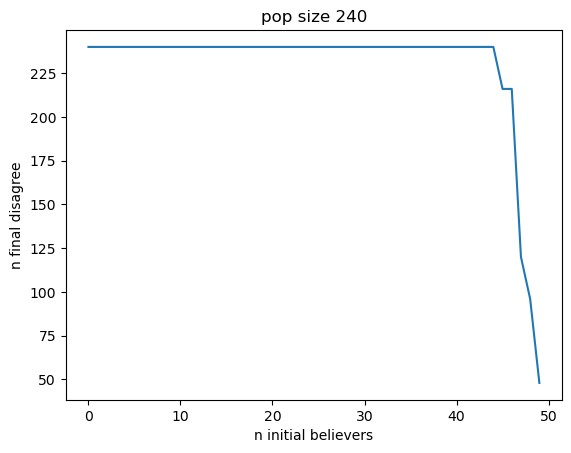

In [88]:
dim=[50,implementations_u]
perc_initial_believers=0.00
p_opinion_change_u=0.5
steps_u=implementations #for now, for simplicity, we run model as many times as we analyze graphs
a=np.zeros(dim)
for i in range(dim[0]):
    perc_initial_believers= perc_initial_believers+0.01
    for j in range(dim[1]):
        
        def initiate_and_run_model(steps):

            model = network_model(population_size = number_nodes, n_initial_believers = int(np.floor(perc_initial_believers*number_nodes)), p_opinion_change = p_opinion_change_u)
    
            for k in range(steps_u):
                model.step()
    
            return model

        model = initiate_and_run_model(steps_u)
        X = sum_agents(model)
        Y=X.values.tolist()
        a[i,j]=int(Y[steps_u-1][0])
print(a)
b=np.arange(0, (dim[0]), dtype=int)
c=np.mean(a,axis=1)
dim=[np.size(c,0),2]
resultsmatrix=np.zeros(dim)
resultsmatrix[:,0]=b
resultsmatrix[:,1]=c
print(resultsmatrix)
plt.plot(resultsmatrix[:,0],resultsmatrix[:,1]) 
plt.title("pop size " + str(number_nodes)) 
plt.xlabel("n initial believers") 
plt.ylabel("n final disagree")
plt.show()